DATA LOADING and stuff

In [26]:
# Install all required packages using conda (safer on Mac & Anaconda)
!conda install -y -c conda-forge pyarrow fsspec huggingface_hub datasets
!conda install -y -c conda-forge pyarrow pandas --force-reinstall
!pip install numpy pandas matplotlib scikit-learn statsmodels

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/anaconda3/envs/truthfulqa

  added / updated specs:
    - pandas
    - pyarrow





Preparing transaction: done
Verifying transaction: done
Executing transaction: done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.6 MB/s  0:00:00 eta 

In [31]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

In [36]:
import pandas as pd
df1 = pd.read_parquet("hf://datasets/truthfulqa/truthful_qa/generation/validation-00000-of-00001.parquet")
import pandas as pd
df2 = pd.read_parquet("hf://datasets/truthfulqa/truthful_qa/multiple_choice/validation-00000-of-00001.parquet")

df1.to_csv("truthful_qa_validation.csv", index=False)
df2.to_csv("truthful_qa_validation.csv", index=False)

df1['ai_correct'] = df1.apply(lambda row: row['best_answer'] in row['correct_answers'], axis=1)


In [37]:

from datasets import load_dataset

ds = load_dataset("truthfulqa/truthful_qa", "generation")

DATA VISUALIZATION

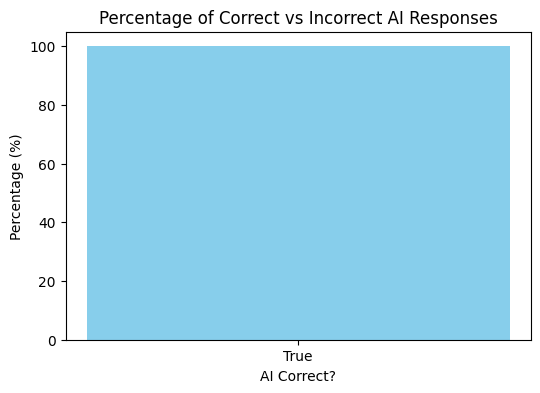

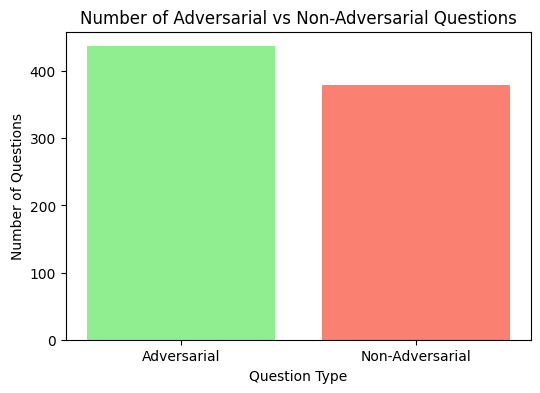

In [43]:
#Outcome Variable Plots
counts = df1['ai_correct'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values, color=['skyblue', 'salmon'])
plt.ylabel('Percentage (%)')
plt.xlabel('AI Correct?')
plt.title('Percentage of Correct vs Incorrect AI Responses')
plt.show()

#Key Explanatory Variable Plots
type_counts = df1['type'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(type_counts.index, type_counts.values, color=['lightgreen','salmon'])
plt.xlabel('Question Type')
plt.ylabel('Number of Questions')
plt.title('Number of Adversarial vs Non-Adversarial Questions')
plt.show()